In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import matplotlib.dates as mdates
import re
import datetime

In [2]:
# Assuming you have longitude and latitude arrays with 0.25-degree resolution
lat = np.linspace(25, 80, 220)
lon = np.linspace(-180, -60, 480)

In [3]:
# Specify the desired longitude and latitude
desired_lon = -121.50
desired_lat = 50.25

# Calculate the indices for the desired grid point
lon_index = int(round((desired_lon - lon[0]) / 0.25))
lat_index = int(round((lat[0]-desired_lat ) / 0.25))

lon_index

lat_index

-101

In [4]:
#era5
ds_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/era5/2021.h5')
lytton_t2m = ds_era.fields[:,2,260:40:-1,720:1200]
lytton_t2m_1 = lytton_t2m[:,101,234]
lytton_t2m_1
ds_era_t2m = lytton_t2m_1[656:693]

In [5]:
#fcn
lat_fcn = np.arange(80, 25, -0.25)
lon_fcn = np.arange(-180, -60, 0.25)
lon_index_fcn = int(round((desired_lon - lon_fcn[0]) / 0.25))
lat_index_fcn = int(round((lat_fcn[0]-desired_lat ) / 0.25))
lon_index_fcn

lat_index_fcn



ds_fcn_21 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_21

ds_fcn_era_data =ds_fcn_21.forecast[:,0,:,2,119,234]
#phony_dim_4-lat phony_dim_5-lon phony_dim_0-time phony_dim_2-leadtime phony_dim_1-pertubated members phony_dim_3:variables
ds_fcn_era_data 

<xarray.DataArray 'forecast' (phony_dim_0: 21, phony_dim_2: 57)>
[1197 values with dtype=float64]
Coordinates:
    phony_dim_3  int64 2
  * phony_dim_0  (phony_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19 20
    phony_dim_1  int64 0
  * phony_dim_2  (phony_dim_2) int64 0 1 2 3 4 5 6 7 ... 49 50 51 52 53 54 55 56
    phony_dim_4  int64 119
    phony_dim_5  int64 234

In [6]:


#ECMWF index check
ds_ecmwf = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_cf_20210615_00_sfc.nc')
ds_ecmwf

lon_ec = ds_ecmwf['longitude']
lat_ec = ds_ecmwf['latitude']
lon_ec
#ds_ecmwf.t2m[0,,:]
indices_lat = np.where(lat_ec == desired_lat)[0]
indices_lat

indices_lon = np.where(lon_ec == desired_lon)[0]
indices_lon

#ECMWF
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_sfc\.nc'

files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
files

data_ec = []
for file in files:
    file_path = os.path.join(directory, file)
    # Extract the date from the filename
    #date_str = re.search(r'\d{8}_\d{2}', file).group(0)
    #date = datetime.datetime.strptime(date_str, '%Y%m%d_%H').date()
    # Read the file and extract the desired variable
    ds = xr.open_dataset(file_path)
    variable_data = ds['t2m'][:,119,234]

    #time_coord = xr.DataArray([date], dims='time1', coords={'time1': [date]})
    #variable_data = variable_data.expand_dims(dim='time1')
    #variable_data = variable_data.assign_coords(time=time_coord)

    data_ec.append(variable_data)

#combined_data = xr.concat(data, dim='time1')
#combined_data
#combined_data[0,:,119,234]
np.shape(data_ec)

#ds_ecmwf.t2m[0,79:159,194:274]
data_array_ec =xr.DataArray(data_ec)
data_array_ec

<xarray.DataArray (dim_0: 21, dim_1: 57)>
array([[287.39014, 281.90308, 278.05518, ..., 282.333  , 290.3806 ,
        292.36377],
       [286.42725, 281.77197, 276.51147, ..., 280.74292, 293.7378 ,
        295.11987],
       [285.50464, 278.85205, 276.22046, ..., 284.10376, 289.76758,
        296.06372],
       ...,
       [297.02417, 288.31006, 285.76245, ..., 282.6482 , 295.6858 ,
        297.90405],
       [297.77612, 290.2107 , 284.71948, ..., 286.10742, 300.3147 ,
        303.43896],
       [298.76562, 289.96387, 284.4519 , ..., 283.21655, 293.7024 ,
        292.29907]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1

In [7]:
#fcn_ecmwf
directory_fcn_ec = '/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/'
filename_pattern_fcn_ec = r'\d{8}_00_backtransformed\.nc'
#fc_cf_20210615_00_sfc.nc
#20210704_00_backtransformed.nc
files_fcn_ec = sorted([f for f in os.listdir(directory_fcn_ec) if re.match(filename_pattern_fcn_ec, f)])
files_fcn_ec

data_fcn_ec = []
for file1 in files_fcn_ec:
    file_path_fcn_ec = os.path.join(directory_fcn_ec, file1)
    # Extract the date from the filename
    date_str = re.search(r'\d{8}', file1).group(0)
    
    date = datetime.datetime.strptime(date_str, '%Y%m%d').date()
    # Read the file and extract the desired variable
    ds_fcn_ec = xr.open_dataset(file_path_fcn_ec)
    variable_data_fcn_ec =  ds_fcn_ec['forecast'][50,:,2,119,234]
    data_fcn_ec.append(variable_data_fcn_ec)

data_array_fcn_ec =xr.DataArray(data_fcn_ec) 
data_array_fcn_ec 
data_array_fcn_ec[:,0] = data_array_ec[:,0]
#data_array_fcn_ec

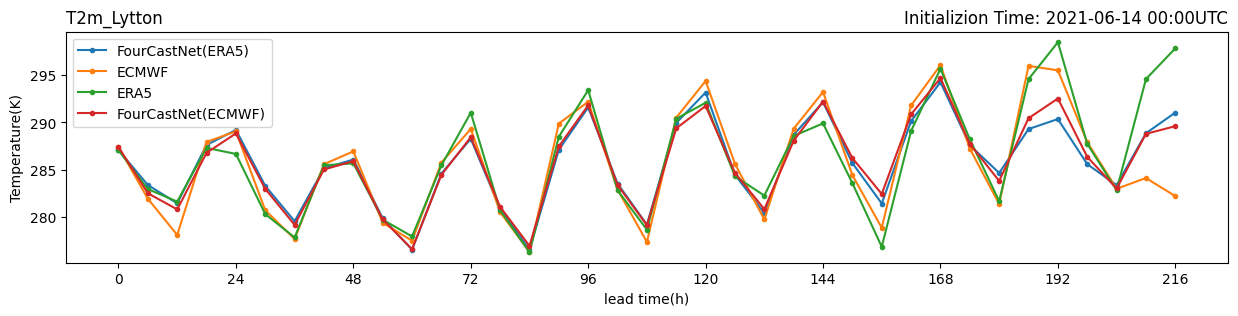

In [16]:
#creating plots 
fig1 = plt.figure(figsize=(15,3))
x = np.linspace(0,36,37)
plt.plot(x, ds_fcn_era_data[0,0:37],'.-',label = 'FourCastNet(ERA5)')
plt.plot(x, data_array_ec[0,0:37],'.-',label = 'ECMWF')
#data_array_ec[0,:,119,234]
plt.plot(x, ds_era_t2m,'.-',label = 'ERA5')
plt.plot(x, data_array_fcn_ec[0,0:37],'.-',label = 'FourCastNet(ECMWF)')

# Set the plot title and labels
plt.title('T2m_Lytton',loc='left')
plt.title('Initializion Time: 2021-06-14 00:00UTC',loc='right')
plt.xlabel('lead time(h)')
plt.ylabel('Temperature(K)')
labels = [0,24,48,72,96,120,144,168,192,216]
#plt.plot(x,y, 'r')
plt.xticks(np.arange(min(x), max(x)+1, 4),labels)
#plt.xticks(x, labels)
plt.legend()
#plt.xticks(x*6)
#plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Adjust the date format as needed
#plt.xticks(rotation=45)
#make the x axis tick evenly distributed
#point out the highest point?
#plot seperately or together?
# Display the plot
plt.show()

In [17]:
#craeting plots function
def make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,time):
    fig1 = plt.figure(figsize=(15,3))
    x = np.linspace(0,36,37)
    plt.plot(x, data_fcn_era,'.-',label = 'FourCastNet(ERA5)')
    plt.plot(x, data_ec,'.-',label = 'ECMWF')
    #data_array_ec[0,:,119,234]
    plt.plot(x, data_era,'.-',label = 'ERA5')
    plt.plot(x, data_fcn_ec,'.-',label = 'FourCastNet(ECMWF)')

    # Set the plot title and labels
    plt.title('T2m_Lytton',loc='left')
    plt.title(time,loc='right')
    plt.xlabel('lead time(h)')
    plt.ylabel('Temperature(K)')
    labels = [0,24,48,72,96,120,144,168,192,216]
    #plt.plot(x,y, 'r')
    plt.xticks(np.arange(min(x), max(x)+1, 4),labels)
    plt.legend()
    plt.savefig('/home/kit/imk-tro/gj5173/ts-lt/'+time, bbox_inches='tight',dpi=100)
    #plt.xticks(x*6)
    #plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Adjust the date format as needed
    #plt.xticks(rotation=45)
    #make the x axis tick evenly distributed
    #point out the highest point?
    #plot seperately or together?
    # Display the plot
    plt.show()
    

  

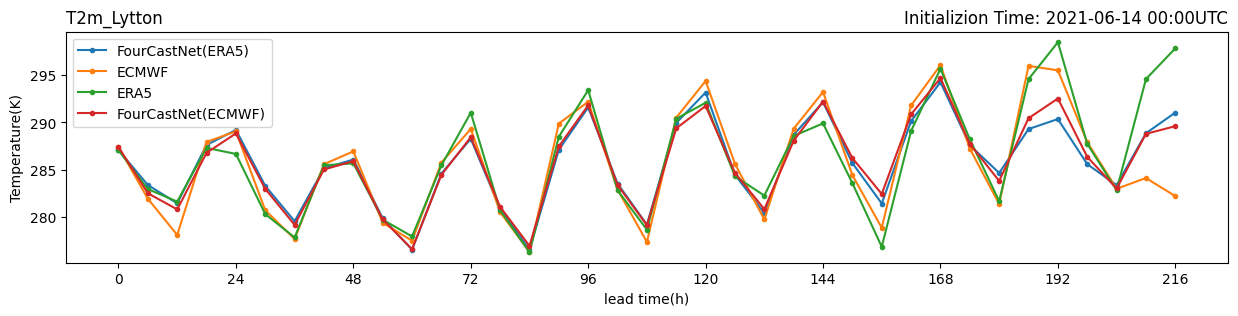

In [47]:
#06.14 00 00
data_fcn_ec = data_array_fcn_ec[0,0:37]
data_ec =  data_array_ec[0,0:37]
data_fcn_era = ds_fcn_era_data[0,0:37]
data_era = lytton_t2m_1[656:693]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-14 00:00UTC')

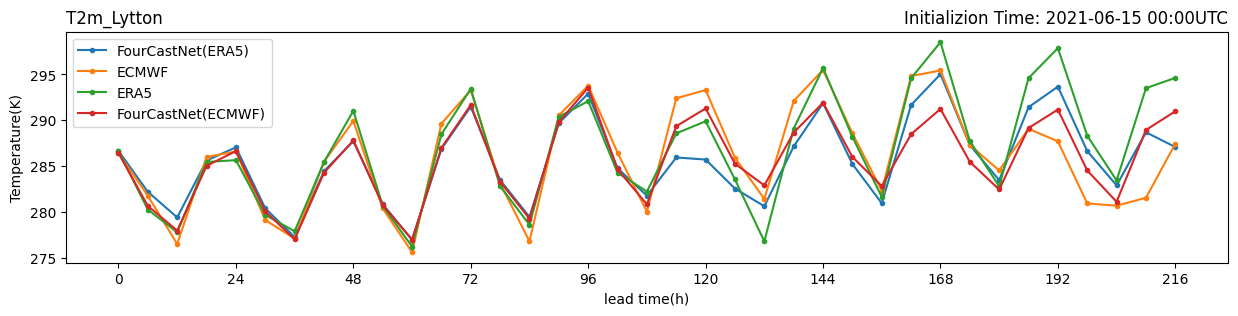

In [48]:
#06.15 00 00
data_fcn_ec = data_array_fcn_ec[1,0:37]
data_ec =  data_array_ec[1,0:37]
data_fcn_era = ds_fcn_era_data[1,0:37]
data_era = lytton_t2m_1[660:697]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-15 00:00UTC')

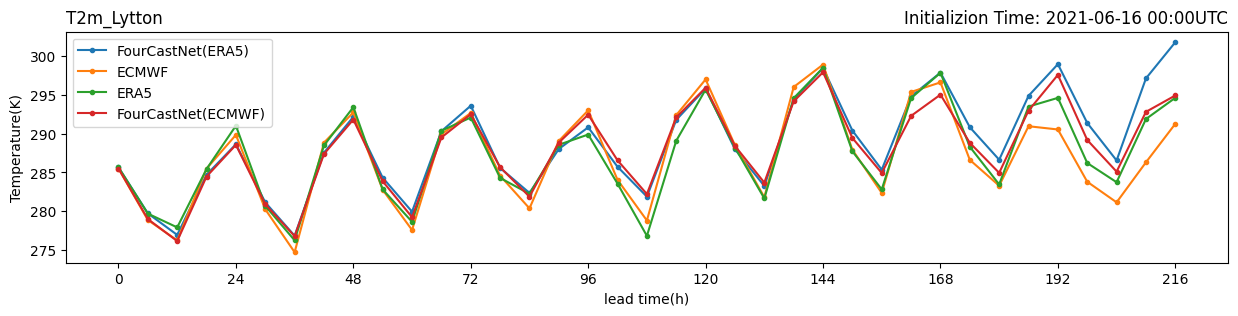

In [49]:
#06.16 00 00
data_fcn_ec = data_array_fcn_ec[2,0:37]
data_ec =  data_array_ec[2,0:37]
data_fcn_era = ds_fcn_era_data[2,0:37]
data_era = lytton_t2m_1[664:701]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-16 00:00UTC')

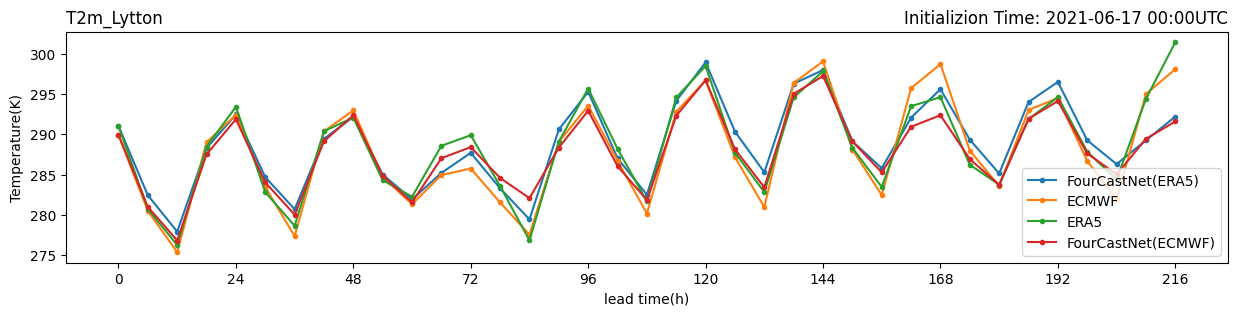

In [50]:
#06.17 00 00
data_fcn_ec = data_array_fcn_ec[3,0:37]
data_ec =  data_array_ec[3,0:37]
data_fcn_era = ds_fcn_era_data[3,0:37]
data_era = lytton_t2m_1[668:705]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-17 00:00UTC')

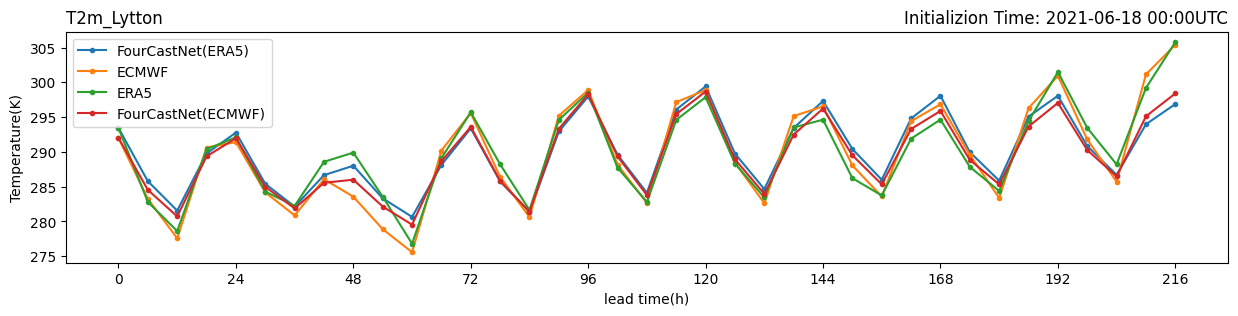

In [51]:
#06.18 00 00
data_fcn_ec = data_array_fcn_ec[4,0:37]
data_ec =  data_array_ec[4,0:37]
data_fcn_era = ds_fcn_era_data[4,0:37]
data_era = lytton_t2m_1[672:709]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-18 00:00UTC')

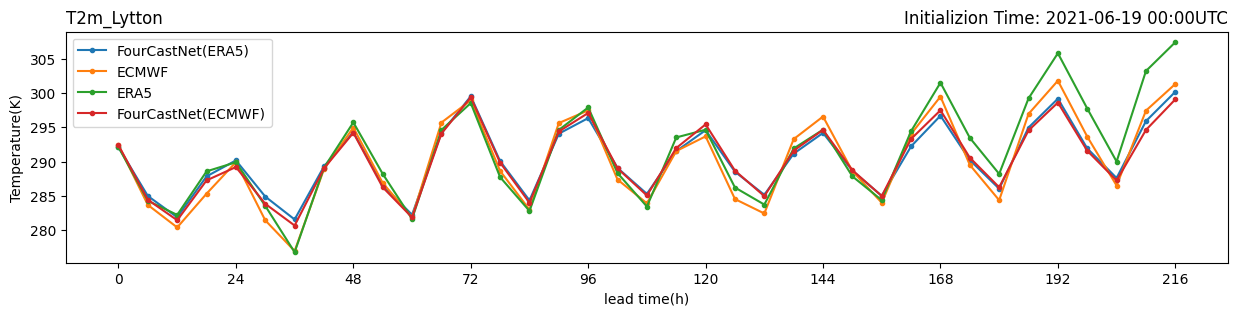

In [52]:
#06.19 00 00
data_fcn_ec = data_array_fcn_ec[5,0:37]
data_ec =  data_array_ec[5,0:37]
data_fcn_era = ds_fcn_era_data[5,0:37]
data_era = lytton_t2m_1[676:713]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-19 00:00UTC')

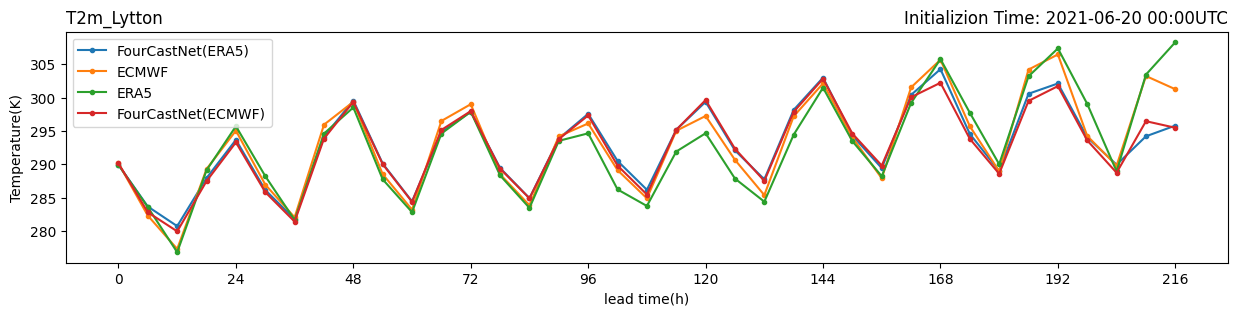

In [53]:
#06.20 00 00
data_fcn_ec = data_array_fcn_ec[6,0:37]
data_ec =  data_array_ec[6,0:37]
data_fcn_era = ds_fcn_era_data[6,0:37]
data_era = lytton_t2m_1[680:717]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-20 00:00UTC')

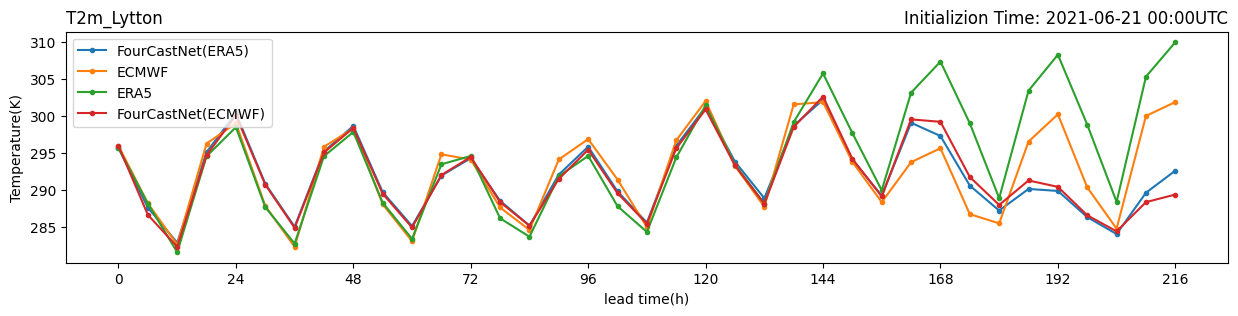

In [54]:
#06.21 00 00
data_fcn_ec = data_array_fcn_ec[7,0:37]
data_ec =  data_array_ec[7,0:37]
data_fcn_era = ds_fcn_era_data[7,0:37]
data_era = lytton_t2m_1[684:721]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-21 00:00UTC')

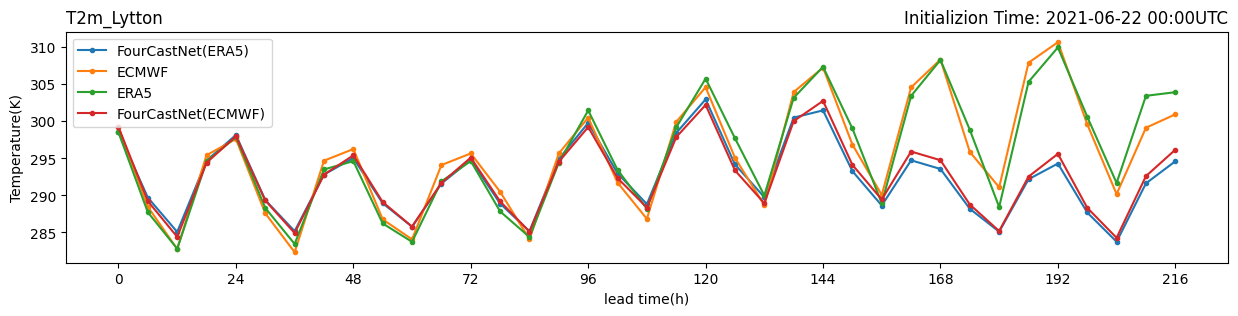

In [55]:
#06.22 00 00
data_fcn_ec = data_array_fcn_ec[8,0:37]
data_ec =  data_array_ec[8,0:37]
data_fcn_era = ds_fcn_era_data[8,0:37]
data_era = lytton_t2m_1[688:725]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-22 00:00UTC')

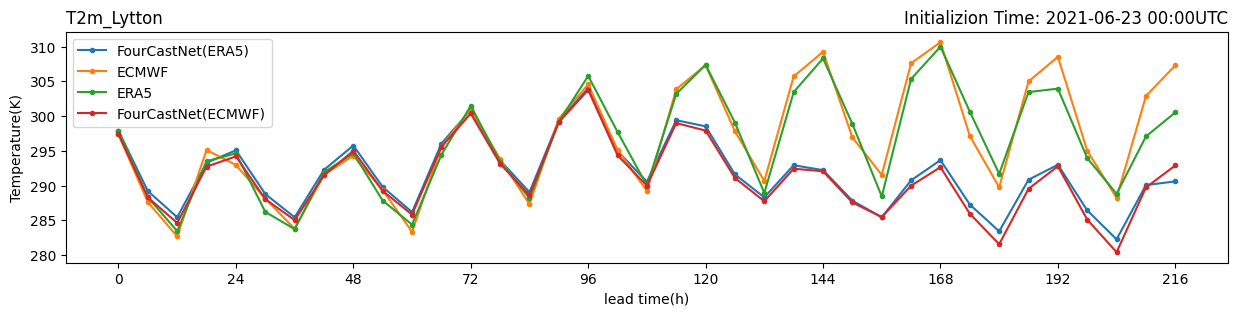

In [56]:
#06.23 00 00
data_fcn_ec = data_array_fcn_ec[9,0:37]
data_ec =  data_array_ec[9,0:37]
data_fcn_era = ds_fcn_era_data[9,0:37]
data_era = lytton_t2m_1[692:729]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-23 00:00UTC')

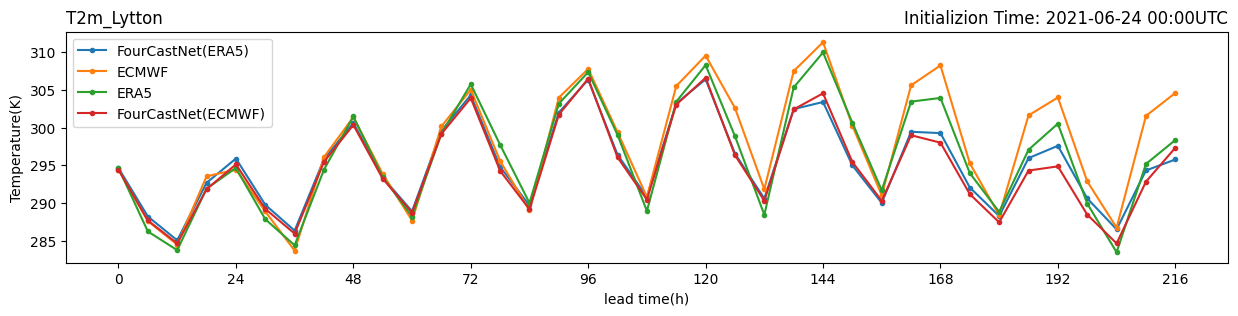

In [57]:
#06.24 00 00
data_fcn_ec = data_array_fcn_ec[10,0:37]
data_ec =  data_array_ec[10,0:37]
data_fcn_era = ds_fcn_era_data[10,0:37]
data_era = lytton_t2m_1[696:733]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-24 00:00UTC')

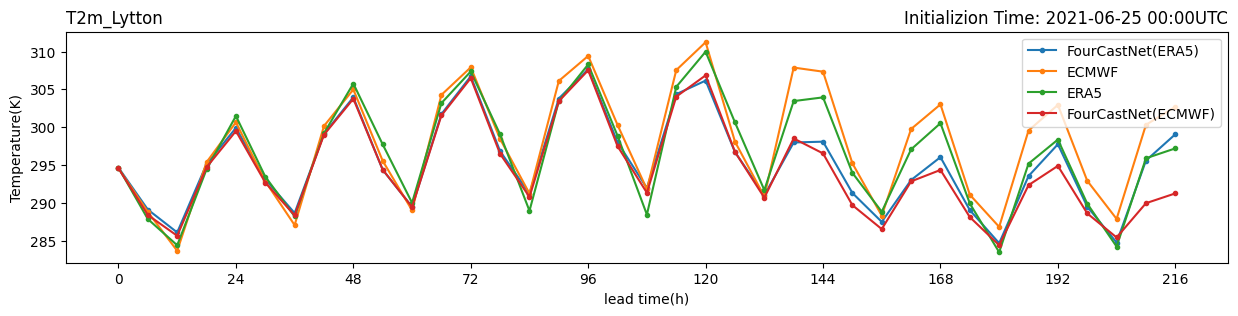

In [58]:
#06.25 00 00
data_fcn_ec = data_array_fcn_ec[11,0:37]
data_ec =  data_array_ec[11,0:37]
data_fcn_era = ds_fcn_era_data[11,0:37]
data_era = lytton_t2m_1[700:737]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-25 00:00UTC')

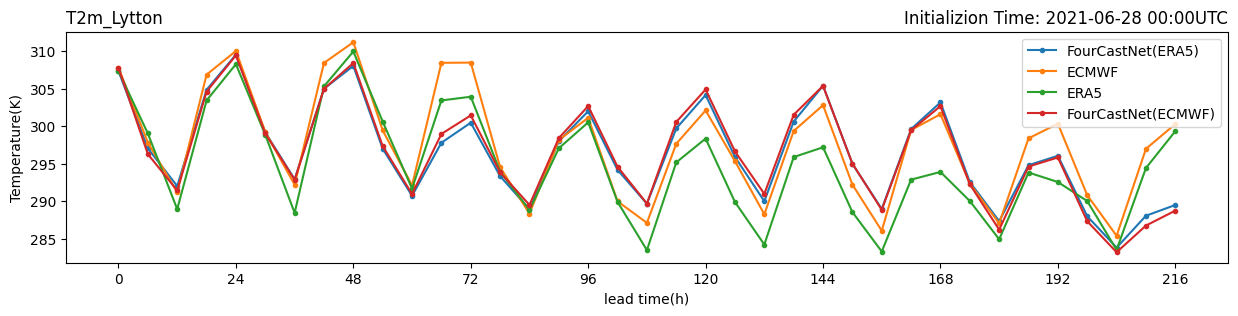

In [59]:
#06.28 00 00
data_fcn_ec = data_array_fcn_ec[14,0:37]
data_ec =  data_array_ec[14,0:37]
data_fcn_era = ds_fcn_era_data[14,0:37]
data_era = lytton_t2m_1[712:749]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-28 00:00UTC')

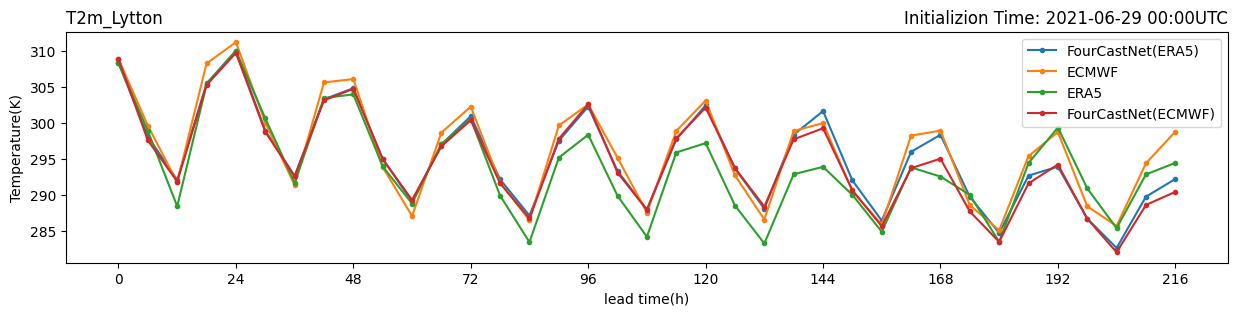

In [60]:
#06.29 00 00
data_fcn_ec = data_array_fcn_ec[15,0:37]
data_ec =  data_array_ec[15,0:37]
data_fcn_era = ds_fcn_era_data[15,0:37]
data_era = lytton_t2m_1[716:753]
make_plots_ts_lt(data_fcn_ec,data_ec,data_fcn_era,data_era,'Initializion Time: 2021-06-29 00:00UTC')